In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [42]:
transform = transforms.Compose([
    transforms.Resize(227),   # AlexNet expects ~227x227
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

In [43]:
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             download=True,
                                             transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            download=True,
                                            transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [44]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [45]:
model = AlexNet(num_classes=10).to(device)

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [47]:
def train_model(model, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {total_loss/len(train_loader):.4f} "
              f"Train Acc: {100*correct/total:.2f}%")

In [48]:
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    print(f"Test Accuracy: {100*correct/total:.2f}%")

In [49]:
train_model(model, epochs=5)
evaluate_model(model)

Epoch [1/5] Loss: 1.5268 Train Acc: 43.71%
Epoch [2/5] Loss: 1.0607 Train Acc: 61.99%
Epoch [3/5] Loss: 0.8348 Train Acc: 70.70%
Epoch [4/5] Loss: 0.6859 Train Acc: 76.01%
Epoch [5/5] Loss: 0.5788 Train Acc: 79.77%
Test Accuracy: 78.15%


In [50]:
import matplotlib.pyplot as plt
import numpy as np

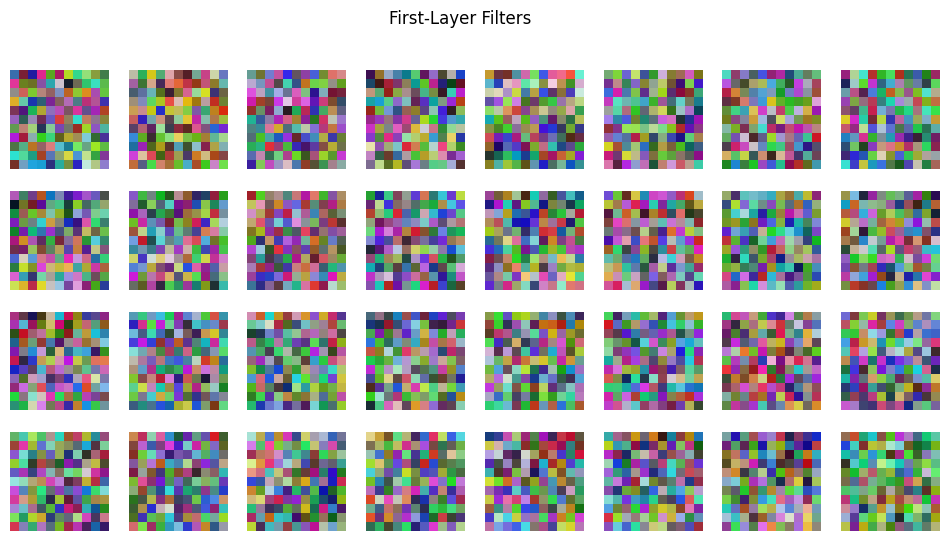

In [51]:
def show_first_layer_filters(model):
    # Get weights from first conv layer
    filters = model.features[0].weight.data.clone().cpu()

    # Normalize to [0,1] for display
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < filters.shape[0]:
            npimg = filters[i].permute(1, 2, 0).numpy()
            ax.imshow(npimg)
        ax.axis('off')
    plt.suptitle("First-Layer Filters")
    plt.show()

show_first_layer_filters(model)

In [52]:
def show_feature_maps(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)

    # We'll capture outputs from first 2 conv layers
    feature_maps = []
    x = image
    for layer in model.features:
        x = layer(x)
        if isinstance(layer, nn.Conv2d):
            feature_maps.append(x.clone().detach().cpu())

    # Plot the feature maps from the 1st and 2nd conv layers
    for idx, fmap in enumerate(feature_maps[:2]):
        fmap = fmap[0]  # first image in batch
        fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min())

        fig, axes = plt.subplots(4, 8, figsize=(12, 6))
        for i, ax in enumerate(axes.flat):
            if i < fmap.shape[0]:
                ax.imshow(fmap[i], cmap='viridis')
            ax.axis('off')
        plt.suptitle(f"Feature Maps - Conv Layer {idx+1}")
        plt.show()

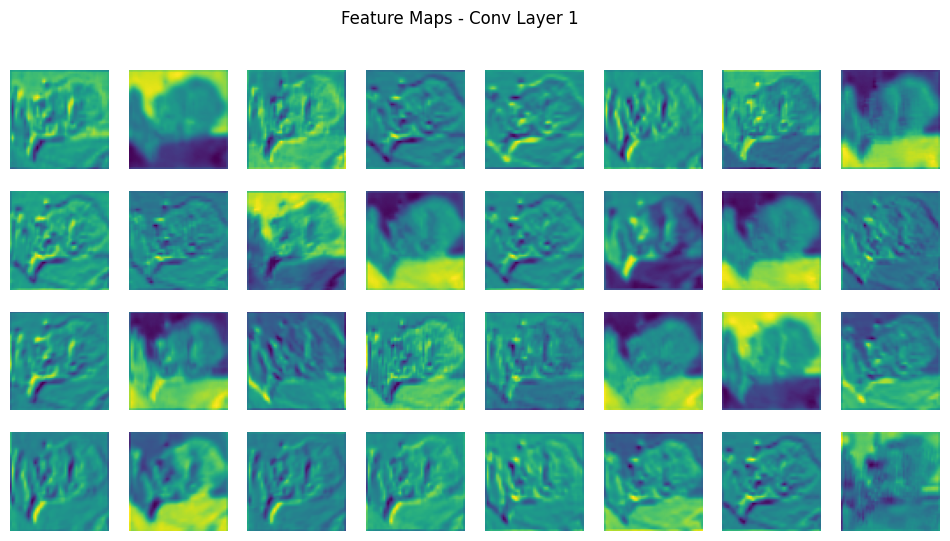

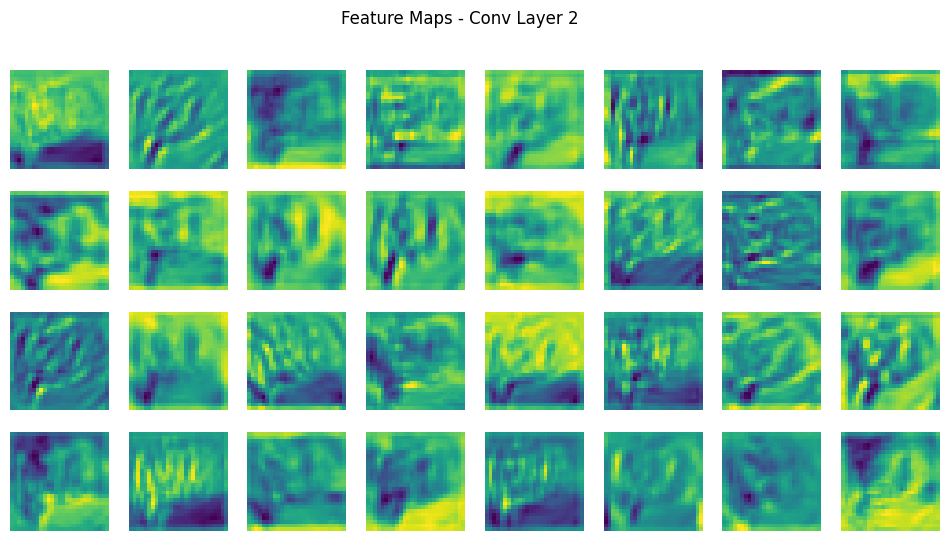

In [53]:
sample_img, _ = test_dataset[0]
show_feature_maps(model, sample_img)

Shape of conv1 weights: (64, 3, 11, 11)


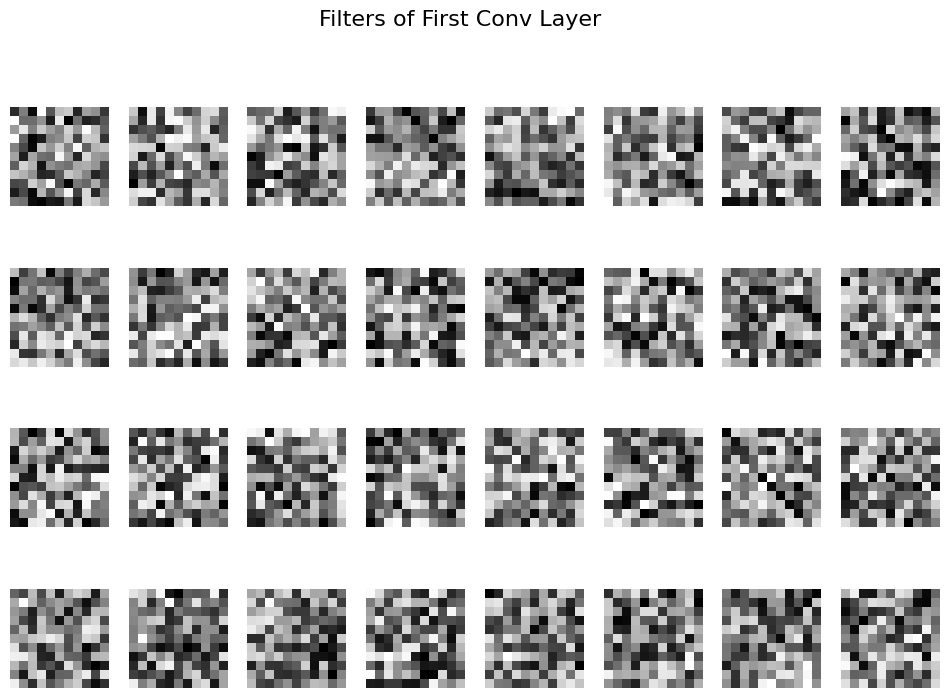

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get the first conv layer
first_conv = model.features[0]

# Extract the weights
weights = first_conv.weight.data.cpu().numpy()

print("Shape of conv1 weights:", weights.shape)  # (out_channels, in_channels, h, w)

# Plot filters
fig = plt.figure(figsize=(12, 8))
for i in range(min(32, weights.shape[0])):  # show first 32 filters
    ax = fig.add_subplot(4, 8, i+1)
    # Take only the first channel for visualization
    w = weights[i, 0, :, :]
    w = (w - w.min()) / (w.max() - w.min())  # normalize to [0,1]
    ax.imshow(w, cmap='gray')
    ax.axis('off')

plt.suptitle('Filters of First Conv Layer', fontsize=16)
plt.show()


Shape of conv1 feature maps: torch.Size([64, 56, 56])


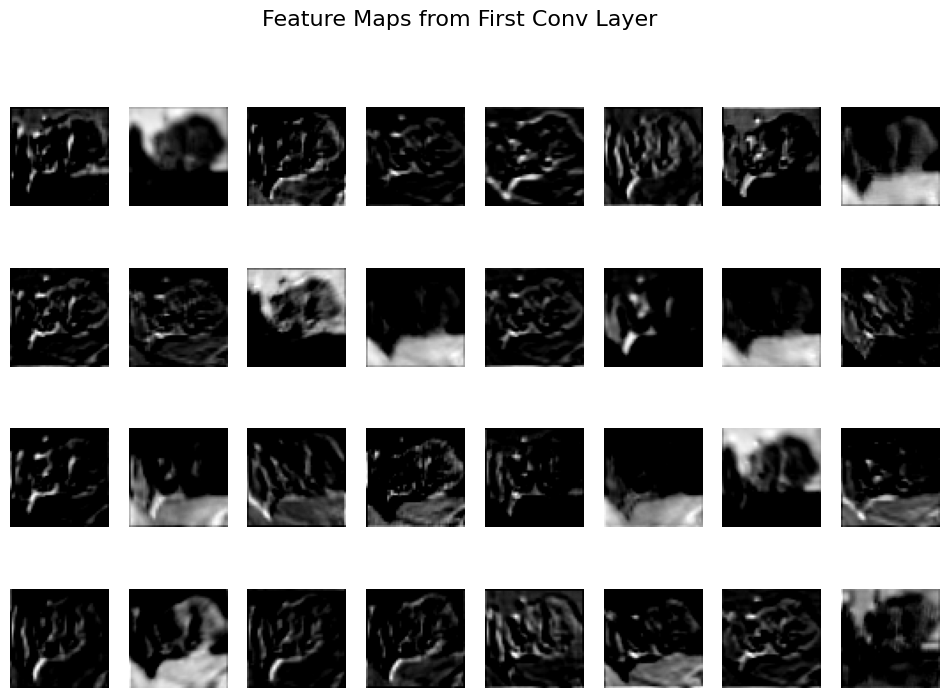

In [55]:
# Choose a sample image from your test dataset
image, label = next(iter(test_loader))
image = image[0].unsqueeze(0).to(device)  # shape (1, C, H, W)

# Hook to extract activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hook on first conv layer
model.features[0].register_forward_hook(get_activation('conv1'))

# Forward pass
model.eval()
with torch.no_grad():
    output = model(image)

# Get the feature maps
act = activation['conv1'].cpu().squeeze()  # shape (num_filters, H, W)

print("Shape of conv1 feature maps:", act.shape)

# Plot feature maps
fig = plt.figure(figsize=(12, 8))
for i in range(min(32, act.shape[0])):
    ax = fig.add_subplot(4, 8, i+1)
    a = act[i]
    a = (a - a.min()) / (a.max() - a.min())
    ax.imshow(a, cmap='gray')
    ax.axis('off')

plt.suptitle('Feature Maps from First Conv Layer', fontsize=16)
plt.show()
